# Harris County Home Price Estimations


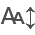

In [1]:
import os
import sqlite3
from datetime import datetime

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from itables import init_notebook_mode, show
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from load_to_dataframe import load_housing_data, load_mailing_data

init_notebook_mode(all_interactive=True)
%matplotlib inline

# Load Data
In the file **load_to_dataframe.py** there is a function that will load the housing data from the *housing_data.zip* into a data frame. There was some processing of the data so that the CSV would be under 100mb to work with a git repo. Below are the filter that took place. 

* Only houses with improvement type 1001 (single family homes) will be selected
* The date erected must be greater than 1900
* The assessed value must be greater than 0
* the square footage must be greater than 50

In [2]:
df = load_housing_data()

# Haversine Function
The haversine function is used to calculate the distance between two sets of latitude and longitude coordinates. In this case one of the fixed points is the center of downtown Houston (29.760100, -95.370100). The assumption is, the closer to Houston's downtown, the higher the value.

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    r = 3958.8
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r * c


# Define the single point (latitude, longitude) to calculate the distance from
single_point = (29.760100, -95.370100)  # Houston

# Add a new column with distances
df["distance_miles"] = df.apply(
    lambda row: haversine(
        single_point[0], single_point[1], row["latitude"], row["longitude"]
    ),
    axis=1,
)

# Grouping Account Numbers
There are multiple account numbers for properties with multiple buildings, and most of the data is repeated for the different buildings other than the bld_num, date_erected, im_sq_ft, dscr_e, and the perimeter. The rest of the features can have the mean taken and it will be the same number pressent. 
The dscr_e is an ordial field and the average of the buildings will be used. 

In [4]:
df = (
    df.groupby("acct")
    .agg(
        bld_num=("bld_num", "max"),
        date_erected=("date_erected", "min"),
        im_sq_ft=("im_sq_ft", "sum"),
        land_ar=("land_ar", "mean"),
        perimeter=("perimeter", "sum"),
        bedrooms=("bedrooms", "mean"),
        full_bath=("full_bath", "mean"),
        half_bath=("half_bath", "mean"),
        total_rooms=("total_rooms", "mean"),
        dscr_e=("dscr_e", "mean"),
        frame_detached_garage=("frame_detached_garage", "mean"),
        gunite_pool=("gunite_pool", "mean"),
        pool_heater=("pool_heater", "mean"),
        solar_panel=("solar_panel", "mean"),
        brick_garage=("brick_garage", "mean"),
        canopy_residential=("canopy_residential", "mean"),
        frame_abov=("frame_abov", "mean"),
        frame_shed=("frame_shed", "mean"),
        carport_residential=("carport_residential", "mean"),
        foundation_repaired=("foundation_repaired", "mean"),
        cracked_slab=("cracked_slab", "mean"),
        latitude=("latitude", "mean"),
        longitude=("longitude", "mean"),
        distance_miles=("distance_miles", "mean"),
        land_val=("land_val", "mean"),
        bld_val=("bld_val", "mean"),
        assessed_val=("assessed_val", "mean"),
    )
    .reset_index()
)
df["assessed_per_sqft"] = df["assessed_val"] / df["im_sq_ft"]
df

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  \
0          20720000014        1          2019      2534   5564.0        452   
1          21440000001        1          2004      2537   5000.0        314   
2          21480000002        1          1917      1496   5000.0        186   
3          21650000007        1          2015      3387   5000.0        578   
4          21650000011        1          2003      1508   6250.0        210   
...                ...      ...           ...       ...      ...        ...   
1095586  1938003804013        1          2003      2117   5250.0        318   
1095587  1938003804014        1          2003      1611   5250.0        184   
1095588  1953050320690        1          1979      2168   6820.0        232   
1095589  1953080320060        1          1983      1723   7575.0        216   
1095590  1955020050280        1          1979      1374   8851.0        250   

         bedrooms  full_bath  half_bath  total_rooms  ...  \
0             3.0        3.0        1.0          6.0  ...   
1             3.0        2.0        1.0          8.0  ...   
2             3.0        1.0        0.0          6.0  ...   
3             3.0        3.0        1.0          6.0  ...   
4             3.0        2.0        0.0          5.0  ...   
...           ...        ...        ...          ...  ...   
1095586       3.0        2.0        1.0          7.0  ...   
1095587       3.0        2.0        0.0          6.0  ...   
1095588       3.0        2.0        0.0          5.0  ...   
1095589       3.0        2.0        0.0          6.0  ...   
1095590       3.0        2.0        1.0          5.0  ...   

         carport_residential  foundation_repaired  cracked_slab   latitude  \
0                        0.0                  0.0           0.0  29.743903   
1                        0.0                  0.0           0.0  29.740005   
2                        0.0                  0.0           0.0  29.742185   
3                        0.0                  0.0           0.0  29.741158   
4                        0.0                  0.0           0.0  29.741294   
...                      ...                  ...           ...        ...   
1095586                  0.0                  0.0           0.0  29.594555   
1095587                  0.0                  0.0           0.0  29.594558   
1095588                  0.0                  0.0           0.0  29.694444   
1095589                  0.0                  0.0           0.0  29.694102   
1095590                  0.0                  0.0           0.0  29.702614   

         longitude  distance_miles  land_val   bld_val  assessed_val  \
0       -95.356534        1.383701  253352.0  451951.0      705303.0   
1       -95.358428        1.554979  200000.0  307658.0      510178.0   
2       -95.361765        1.334974  200000.0    9486.0      209586.0   
3       -95.361889        1.398421  200000.0  523919.0      723919.0   
4       -95.361493        1.398188  225000.0  172034.0      397034.0   
...            ...             ...       ...       ...           ...   
1095586 -95.453635       12.489168   35438.0  233603.0      269041.0   
1095587 -95.453478       12.485174   35438.0  204053.0      239491.0   
1095588 -95.658936       17.914352   54560.0  201010.0      255570.0   
1095589 -95.658271       17.881794   55740.0  173156.0      228896.0   
1095590 -95.673357       18.623451   64580.0  160896.0      225476.0   

         assessed_per_sqft  
0               278.335833  
1               201.094994  
2               140.097594  
3               213.734573  
4               263.285146  
...                    ...  
1095586         127.085971  
1095587         148.659839  
1095588         117.882841  
1095589         132.847359  
1095590         164.101892  

[1095591 rows x 29 columns]

# Price Per Square Foot
This is another metric that I will explore to see if there is a relationship between other values. This data will be cleaned and also a test since any property with 0 square feet will return a divide by zero error, so the row will be dropped.

In [5]:
df["assessed_per_sqft"].describe()

count    1.095591e+06
mean     1.612853e+02
std      7.577921e+01
min      1.785714e+00
25%      1.241200e+02
50%      1.429466e+02
75%      1.695190e+02
max      5.090190e+03
Name: assessed_per_sqft, dtype: float64

In [6]:
df["assessed_val"].describe()

count    1.095591e+06
mean     3.726307e+05
std      4.019996e+05
min      1.000000e+03
25%      2.177670e+05
50%      2.818690e+05
75%      3.887810e+05
max      2.673551e+07
Name: assessed_val, dtype: float64

# Reduce data set to a manageable size
The current data set is over 1.1M rows. This would take **DAYS** to train a model on a regular computer. This is after the initial filtering when extracting the data from the SQLite database.

To reduce the number of houses and remove outliers I will use the inner quartile range to remove the outliers.


In [7]:
print(f"There are {df.shape[0]:,} rows and {df.shape[1]} columns in the df Data Frame.")

There are 1,095,591 rows and 29 columns in the df Data Frame.


In [8]:
# # IQR
# Q1 = df["assessed_val"].quantile(0.25)
# Q3 = df["assessed_val"].quantile(0.75)
# IQR = Q3 - Q1

# lower_iqr = Q1 - 1.5 * IQR
# upper_iqr = Q3 + 1.5 * IQR
# print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

# df = df[(df["assessed_val"] <= upper_iqr)]

In [9]:
df["assessed_val"].describe()

count    1.095591e+06
mean     3.726307e+05
std      4.019996e+05
min      1.000000e+03
25%      2.177670e+05
50%      2.818690e+05
75%      3.887810e+05
max      2.673551e+07
Name: assessed_val, dtype: float64

In [10]:
y = df["assessed_val"]
y_per_sqft = df["assessed_per_sqft"]

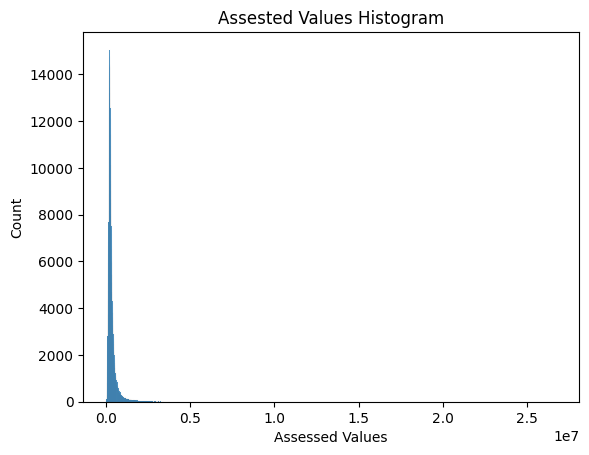

In [11]:
sns.histplot(y)
plt.xlabel("Assessed Values")
plt.ylabel("Count")
plt.title("Assested Values Histogram")
plt.show()

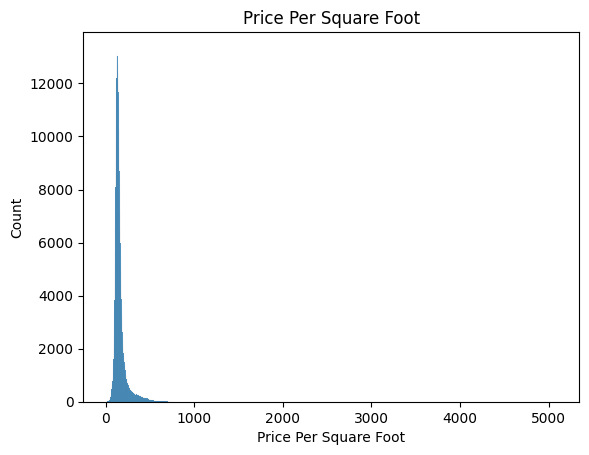

In [12]:
sns.histplot(y_per_sqft)
plt.xlabel("Price Per Square Foot")
plt.ylabel("Count")
plt.title("Price Per Square Foot")
plt.show()

## Sample Size Reduction
Since the data set is still over 1M homes, we need to reduce the size to create a model. I will use 10 thousand random samples from the full data frame.

In [13]:
sample_df = df.sample(n=10000, random_state=42)
show(sample_df)
# sample_df.to_csv("sample_housing_data.csv")

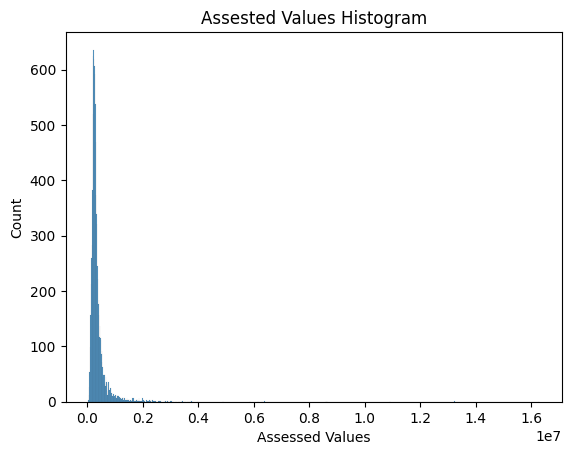

In [14]:
sns.histplot(sample_df["assessed_val"])
plt.xlabel("Assessed Values")
plt.ylabel("Count")
plt.title("Assested Values Histogram")
plt.show()

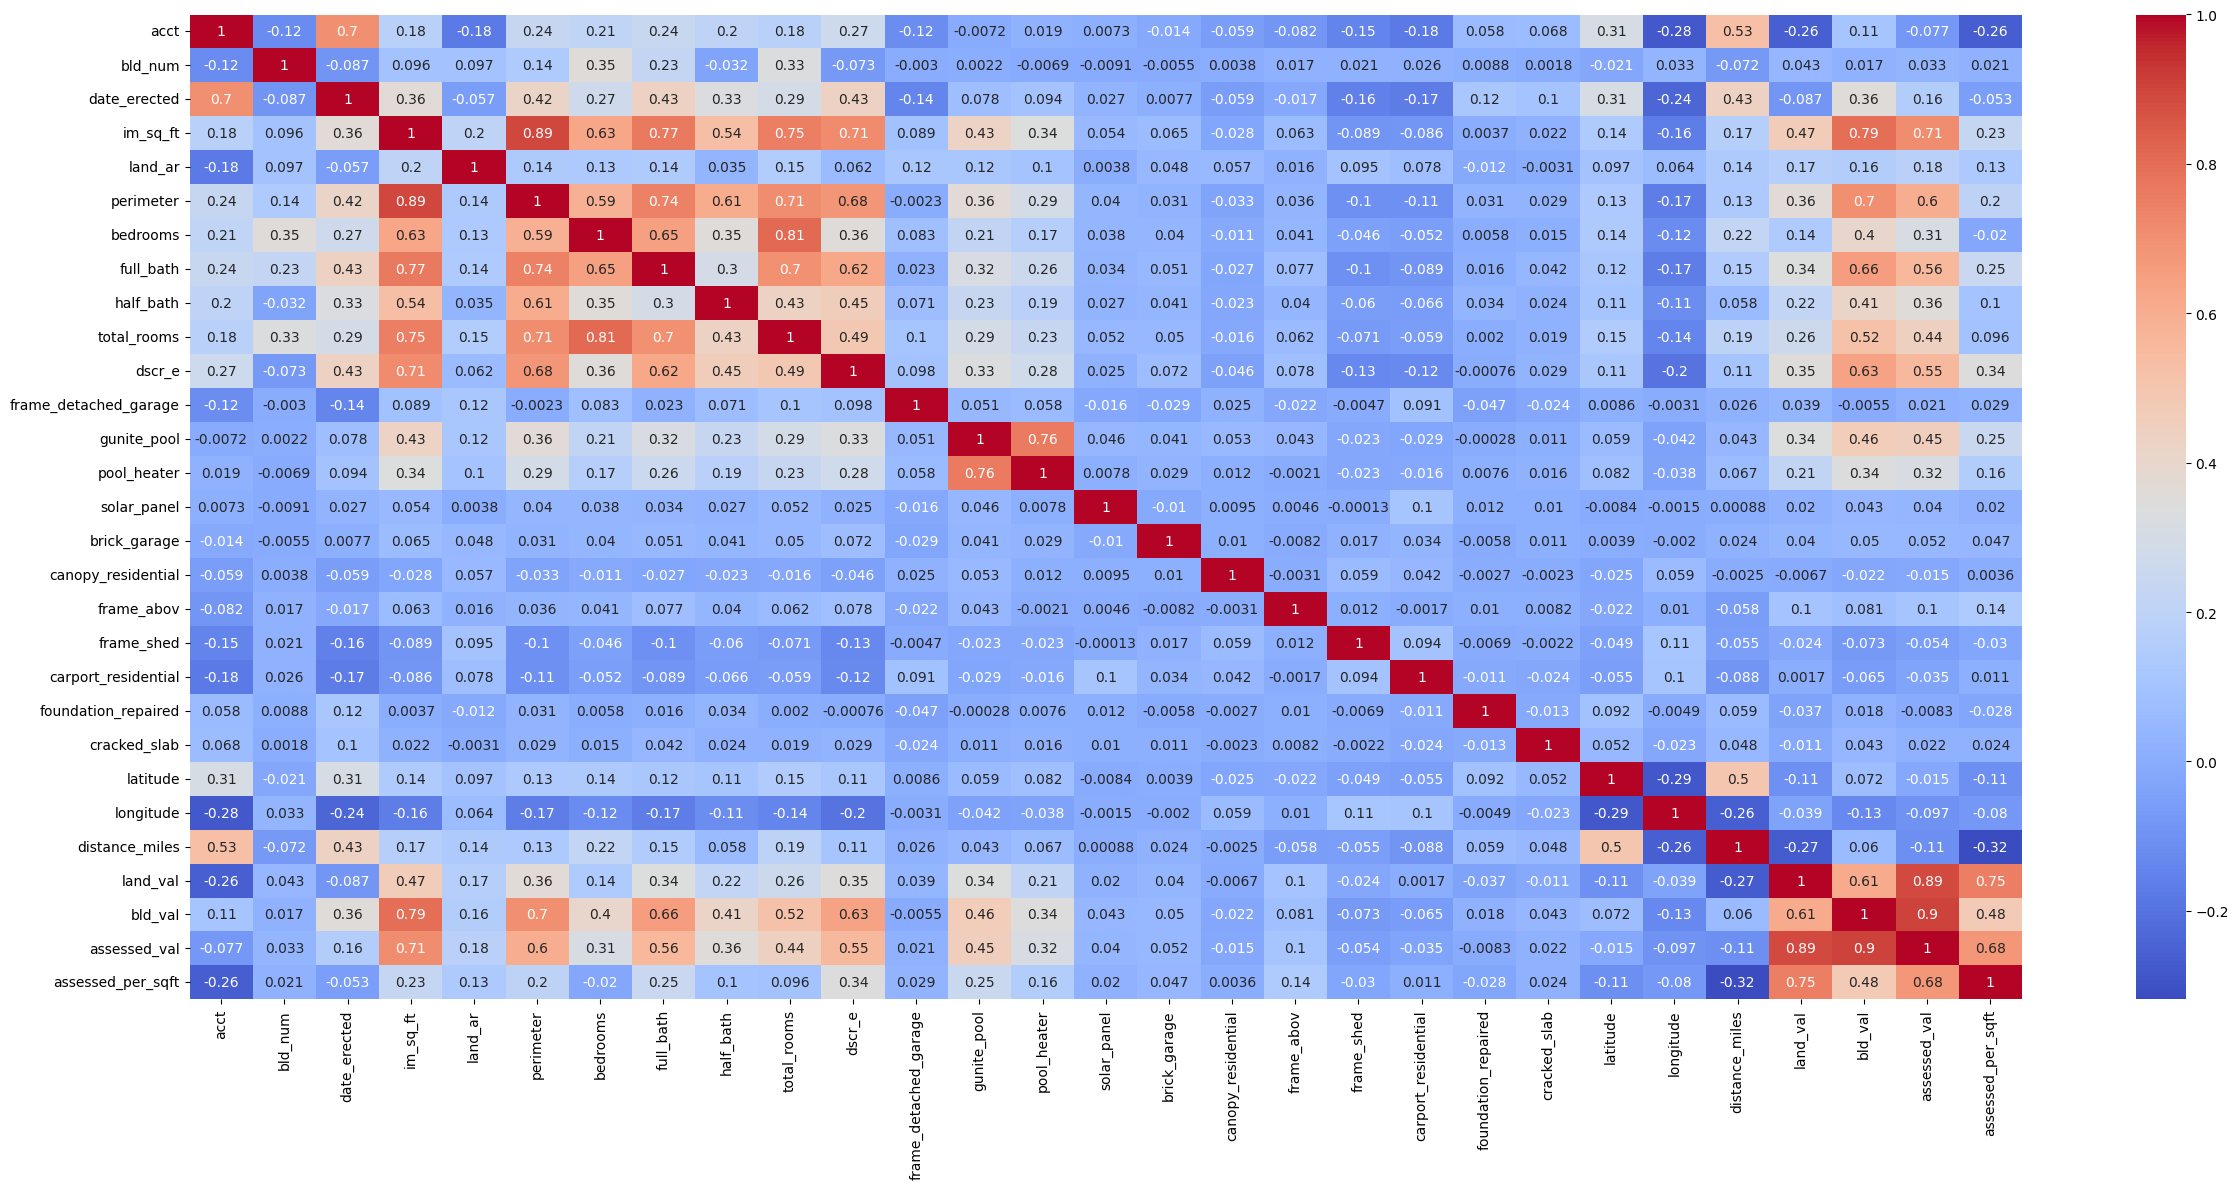

In [15]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

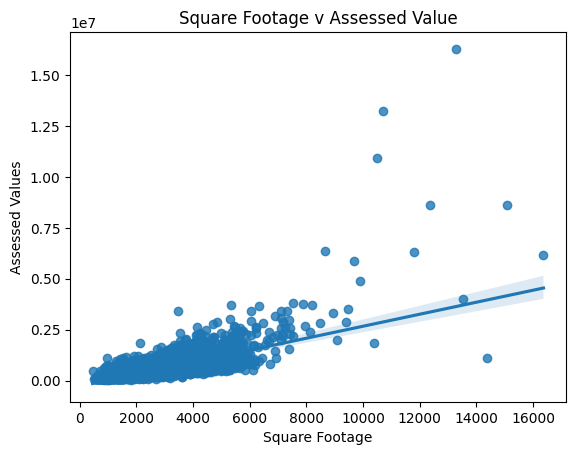

In [16]:
sns.regplot(sample_df, x="im_sq_ft", y="assessed_val")
plt.xlabel("Square Footage")
plt.ylabel("Assessed Values")
plt.title("Square Footage v Assessed Value")
plt.show()

# Create the features as X

In [17]:
X = sample_df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]

y = sample_df["assessed_val"]
print(f"There are {X.shape[1] + 1} features in total.")

There are 23 features in total.


# Train, Test, Split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [19]:
x_train.describe()

date_erected      im_sq_ft        land_ar    perimeter     bedrooms  \
count   7000.000000   7000.000000    7000.000000  7000.000000  7000.000000   
mean    1987.029143   2190.763429    9889.931857   280.545571     3.398000   
std       24.186918   1021.953546   17231.160874   115.975320     0.789013   
min     1904.000000    450.000000       0.000000     0.000000     0.000000   
25%     1970.000000   1524.750000    5989.750000   200.000000     3.000000   
50%     1989.000000   1966.000000    7211.500000   246.000000     3.000000   
75%     2006.000000   2595.000000    9240.000000   338.000000     4.000000   
max     2023.000000  16369.000000  518799.000000  1310.000000    13.000000   

         full_bath    half_bath  total_rooms     latitude    longitude  ...  \
count  7000.000000  7000.000000  7000.000000  7000.000000  7000.000000  ...   
mean      2.121429     0.454571     6.931286    29.832671   -95.424762  ...   
std       0.761518     0.538496     1.669848     0.144536     0.206633  ...   
min       0.000000     0.000000     1.000000    29.500001   -95.936625  ...   
25%       2.000000     0.000000     6.000000    29.712765   -95.587358  ...   
50%       2.000000     0.000000     7.000000    29.828800   -95.437785  ...   
75%       2.000000     1.000000     8.000000    29.946602   -95.253051  ...   
max       9.000000     4.000000    23.000000    30.160779   -94.924981  ...   

        gunite_pool  pool_heater  brick_garage  canopy_residential  \
count   7000.000000  7000.000000   7000.000000         7000.000000   
mean     771.514143   125.833429    117.018714          123.282000   
std     3111.441637   642.201826   1178.547425         1020.625966   
min        0.000000     0.000000      0.000000            0.000000   
25%        0.000000     0.000000      0.000000            0.000000   
50%        0.000000     0.000000      0.000000            0.000000   
75%        0.000000     0.000000      0.000000            0.000000   
max    51728.000000  6715.000000  29350.000000        71884.000000   

         frame_abov   frame_shed  carport_residential  foundation_repaired  \
count   7000.000000  7000.000000          7000.000000          7000.000000   
mean     141.116571   110.854000            88.746857          -119.267714   
std     1726.537082   463.912321           483.227501           952.881937   
min        0.000000     0.000000             0.000000        -13224.000000   
25%        0.000000     0.000000             0.000000             0.000000   
50%        0.000000     0.000000             0.000000             0.000000   
75%        0.000000     0.000000             0.000000             0.000000   
max    47509.000000  9800.000000         14925.000000             0.000000   

       cracked_slab  distance_miles  
count   7000.000000     7000.000000  
mean    -176.921571       15.448546  
std     1736.278674        7.100432  
min   -38640.000000        0.577974  
25%        0.000000        9.723576  
50%        0.000000       15.808414  
75%        0.000000       21.141620  
max        0.000000       41.763552  

[8 rows x 22 columns]

In [20]:
y_train.describe()

count    7.000000e+03
mean     3.702955e+05
std      4.343665e+05
min      3.500000e+04
25%      2.169578e+05
50%      2.800880e+05
75%      3.829162e+05
max      1.628571e+07
Name: assessed_val, dtype: float64

# Extra Random Trees
Using GridSearchCV for hyperparameter tuning. If this is done, it will increase the model's runtime to take several hours, and depending on the sample size and parameters, the computer may need up to 64 GB of RAM to process the models. If the computer has 32 GB, ensure the n_jobs = 4 or less. If the computer has 16gb of ram put n_jobs=1. n_jobs is the parallel jobs going simultaneously and consuming more resources. 

In [21]:
etr = ExtraTreesRegressor(random_state=42)
param_grid = {
    "n_estimators": [4000],
    "min_samples_leaf": [1],
    "min_samples_split": [3],
    "max_features": [10, X.shape[1] + 1],
    "criterion": ["squared_error"],
    "warm_start": [False],
}
etr_cv = GridSearchCV(etr, param_grid, cv=5, n_jobs=3, scoring="neg_mean_squared_error")
etr_cv.fit(x_train, y_train)

c:\Users\Blake\Documents\GitHub\HouseProtestValues\.HouseProtestValues\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42), n_jobs=3,
             param_grid={'criterion': ['squared_error'],
                         'max_features': [10, 23], 'min_samples_leaf': [1],
                         'min_samples_split': [3], 'n_estimators': [4000],
                         'warm_start': [False]},
             scoring='neg_mean_squared_error')

In [22]:
etr_cv.best_score_

np.float64(-32173846267.12553)

In [23]:
etr_cv.best_params_

{'criterion': 'squared_error',
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 4000,
 'warm_start': False}

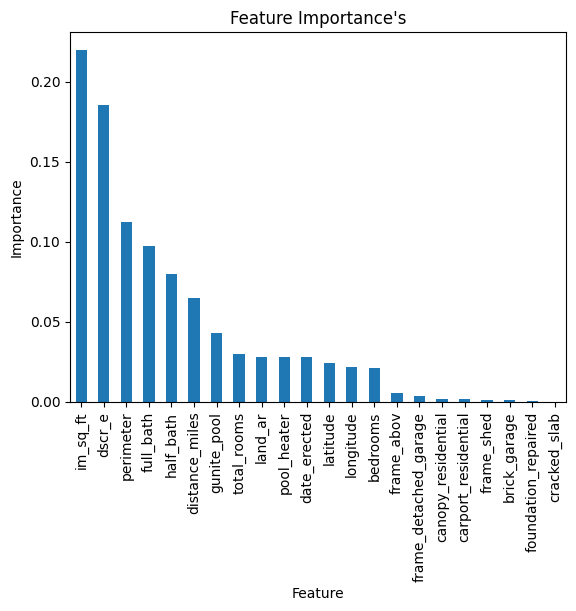

In [24]:
feature_names = [f"{i}" for i in X.columns]
best_model = etr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Graph the importance of the features
importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [25]:
ert_cv_results = pd.DataFrame(etr_cv.cv_results_)
ert_cv_results["param_n_estimators"] = ert_cv_results["param_n_estimators"].astype(
    "category"
)
ert_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      60.350010      0.573637         1.662846        0.038712   
1     104.839668      4.146453         1.599889        0.079187   

  param_criterion  param_max_features  param_min_samples_leaf  \
0   squared_error                  10                       1   
1   squared_error                  23                       1   

   param_min_samples_split param_n_estimators  param_warm_start  \
0                        3               4000             False   
1                        3               4000             False   

                                              params  split0_test_score  \
0  {'criterion': 'squared_error', 'max_features':...      -1.350617e+10   
1  {'criterion': 'squared_error', 'max_features':...      -1.379594e+10   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0      -1.870040e+10      -5.822488e+10      -2.161050e+10      -4.882728e+10   
1      -1.739614e+10      -6.717906e+10      -2.318467e+10      -5.344510e+10   

   mean_test_score  std_test_score  rank_test_score  
0    -3.217385e+10    1.787509e+10                1  
1    -3.500018e+10    2.132990e+10                2

# Savings the model
The model will be save to the hard drive so it can be used later without having to run the entire ExtraTreesRegression model again. 

In [26]:
# Define the folder name
folder_name = "Models"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

# Get the current date
current_date = datetime.now()

# Format the date as YYYYmmdd
formatted_date = current_date.strftime("%Y%m%d")

joblib.dump(etr_cv, f"Models/etc_{formatted_date}_all_data.pkl")

Folder 'Models' already exists.


['Models/etc_20241203_all_data.pkl']

## Analysis of testing data

In [27]:
etr_pred = etr_cv.predict(x_test)
etr_mae = mean_absolute_error(y_test, etr_pred)
etr_mse = mean_squared_error(y_test, etr_pred)
etr_r2 = r2_score(y_test, etr_pred)
print(f"MAE: {etr_mae}\nMSE: {etr_mse}\nR Squared: {etr_r2}\n")

MAE: 54220.338113541664
MSE: 20641772034.681587
R Squared: 0.865613303192484



In [28]:
actual = y_test.to_list()
predicted = etr_cv.predict(x_test)
etc_residuals = pd.DataFrame({"actual": actual, "predicted": predicted})
etc_residuals["residuals"] = etc_residuals["actual"] - etc_residuals["predicted"]

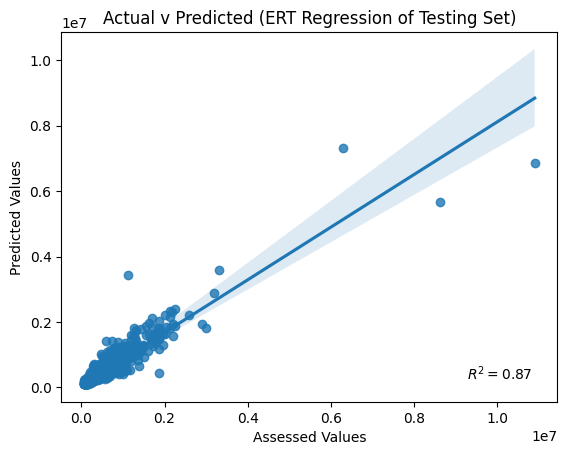

In [29]:
sns.regplot(etc_residuals, x="actual", y="predicted")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Actual v Predicted (ERT Regression of Testing Set)")

plt.text(
    0.95,
    0.05,
    f"$R^2 = {etr_r2:.2f}$",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
)
plt.show()

# Residual Analysis

In [30]:
y_train_pred = etr_cv.predict(x_train)
y_test_pred = etr_cv.predict(x_test)

In [31]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

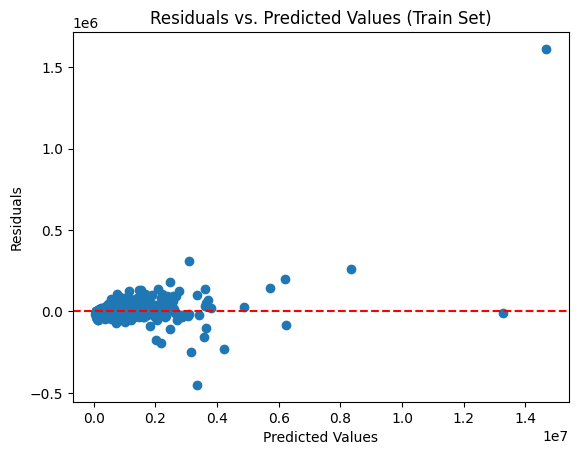

In [32]:
# Train set residuals
plt.scatter(y_train_pred, train_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Train Set)")
plt.show()

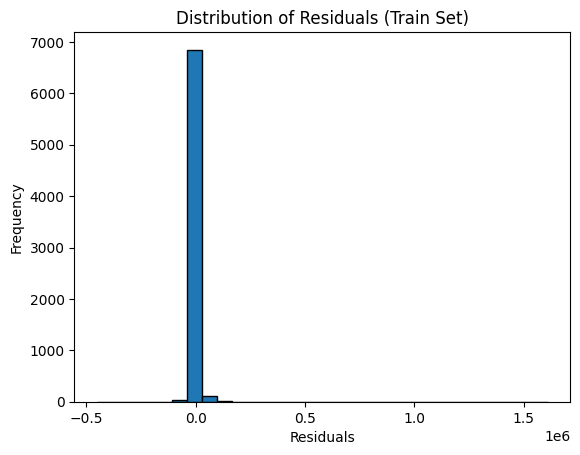

In [33]:
plt.hist(train_residuals, bins=30, edgecolor="k")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Train Set)")
plt.show()

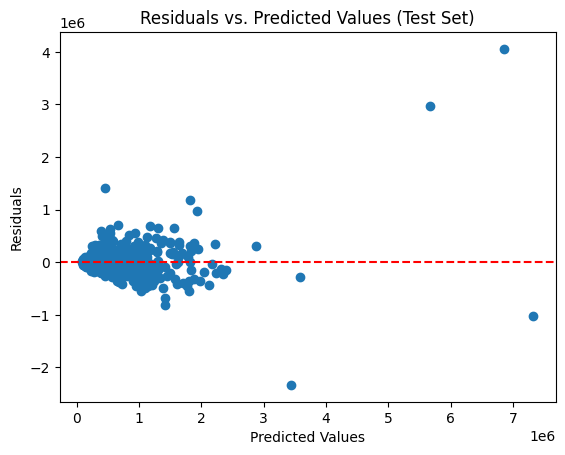

In [34]:
# Test set residuals
plt.scatter(y_test_pred, test_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Test Set)")
plt.show()

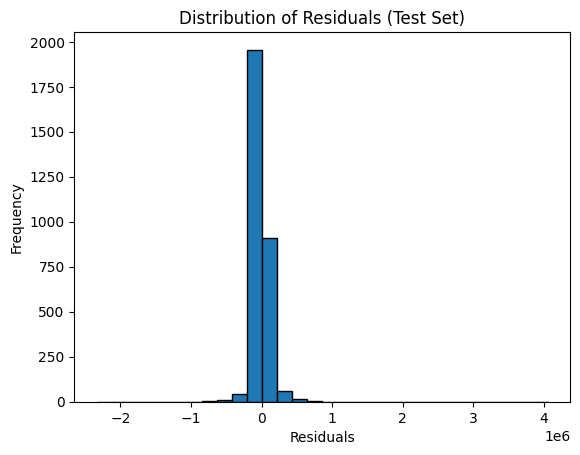

In [35]:
plt.hist(test_residuals, bins=30, edgecolor="k")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Test Set)")
plt.show()

In [36]:
from scipy.stats import shapiro

stat, p = shapiro(test_residuals)
if p > 0.05:
    print(f"Residuals are normally distributed (p > 0.05, p={p}) .")
else:
    print(f"Residuals are not normally distributed (p <= 0.05, p={p}).")

Residuals are not normally distributed (p <= 0.05, p=7.32715798853345e-71).


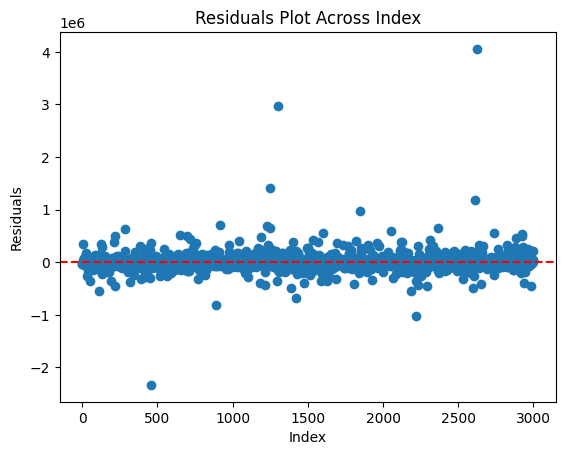

In [37]:
plt.scatter(range(len(y_test)), test_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals Plot Across Index")
plt.show()

## Z-Score of the outliers
These indexes are results that are stastically different from the models prediction and may need to be indivially reviewed. 

In [38]:
import numpy as np

z_scores = np.abs((test_residuals - np.mean(test_residuals)) / np.std(test_residuals))
outliers = np.where(z_scores > 3)
print(f"Outlier indices: {outliers}")

Outlier indices: (array([ 111,  215,  220,  282,  457,  649,  699,  719,  887,  915, 1190,
       1214, 1226, 1246, 1251, 1299, 1389, 1418, 1604, 1847, 2054, 2183,
       2216, 2294, 2366, 2601, 2610, 2623, 2740, 2886, 2921, 2924, 2986]),)


In [39]:
from statsmodels.api import OLS
import statsmodels.api as sm

model_ols = sm.OLS(y_train, sm.add_constant(x_train)).fit()
influence = model_ols.get_influence()
cooks_d = influence.cooks_distance

## Gradient Boosting Regression

Gradient boosting is another ensemble algorithm that can be used much like Extra Random Trees. It differs in the way that it makes the trees. In gradient boosting new trees are added to correct errors of the previous tress in a sequential manner, while extra random trees builds tress independently by randomly selecting features and split points at each node, which makes it less prone to overfitting compared to gradient boosting which can be more sensitive to overfitting.

In [40]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [4000],
    "learning_rate": [0.01, 0.005],
    "max_depth": [5],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": [10, 15, X.shape[1] + 1],
    "warm_start": [True],
    "criterion": ["squared_error"],
}
gbr_cv = GridSearchCV(gbr, param_grid, cv=5, n_jobs=3, scoring="neg_mean_squared_error")

In [41]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

In [42]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

MAE: 44554.58465315918
MSE: 15026837879.44936
R Squared: 0.902168907655393



In [43]:
gbr_cv.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 4000,
 'warm_start': True}

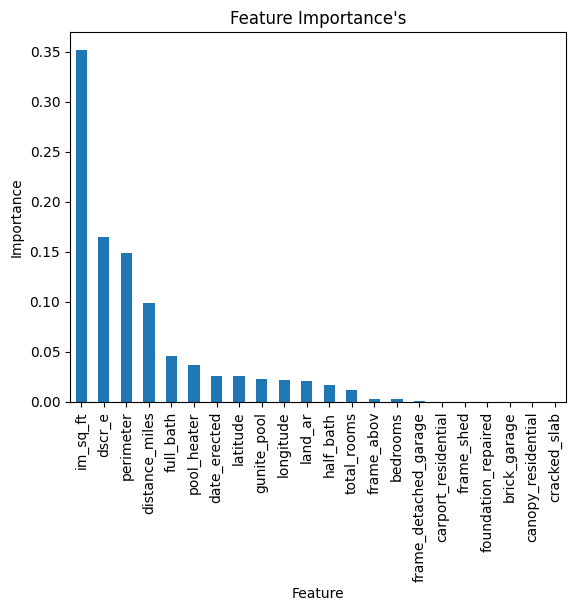

In [44]:
feature_names = [f"{i}" for i in X.columns]
best_model = gbr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Graph the importance of the features
importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [45]:
gbr_cv.best_score_

np.float64(-30484267358.71228)

In [46]:
joblib.dump(gbr_cv, "Models/gbr_all_data.pkl")

# load
# joblib.load('gbr.pkl')

['Models/gbr_all_data.pkl']

In [47]:
gbr_residual_df = pd.DataFrame(
    {
        "actual": actual,
        "predicted": gbr_pred,
    }
)
gbr_residual_df["residuals"] = gbr_residual_df["actual"] - gbr_residual_df["predicted"]

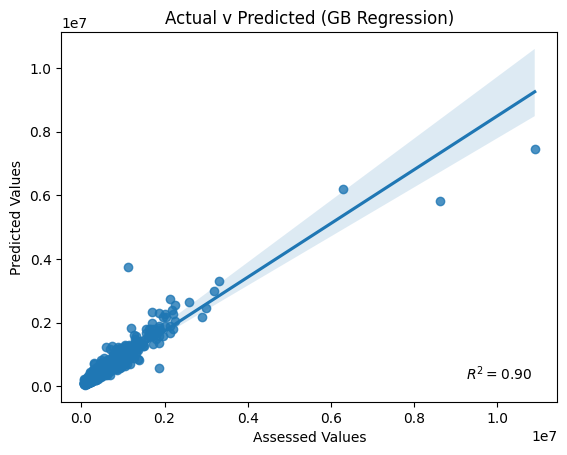

In [48]:
sns.regplot(gbr_residual_df, x="actual", y="predicted")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Actual v Predicted (GB Regression)")

plt.text(
    0.95,
    0.05,
    f"$R^2 = {gbr_r2:.2f}$",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
)
plt.show()

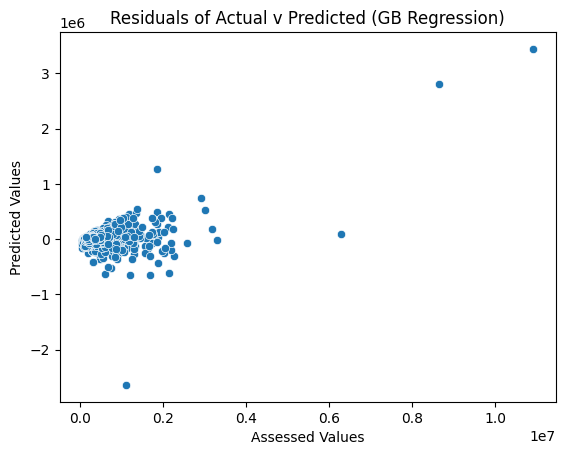

In [49]:
sns.scatterplot(gbr_residual_df, x="actual", y="residuals")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Residuals of Actual v Predicted (GB Regression)")
plt.show()

# Apply model to entire dataset
The model was created with a random subset of the data to reduce the training time. This will apply the model to the rest of the dataset.

In [50]:
X = df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]
df["ert_predicted"] = etr_cv.predict(X)
df["gbr_predicted"] = gbr_cv.predict(X)

In [51]:
df[["assessed_val", "ert_predicted", "gbr_predicted"]]

assessed_val  ert_predicted  gbr_predicted
0            705303.0  653780.711250  624914.629074
1            510178.0  589851.258750  495126.243263
2            209586.0  269623.847250  362935.625022
3            723919.0  835266.986375  854822.957740
4            397034.0  324602.070125  357717.692911
...               ...            ...            ...
1095586      269041.0  275861.973125  260651.670747
1095587      239491.0  236256.891125  226465.813378
1095588      255570.0  260344.418500  250283.584005
1095589      228896.0  235403.276875  227305.334987
1095590      225476.0  213028.280250  204211.709993

[1095591 rows x 3 columns]

# Merge Mailing Address
Merge the Mailing Address information with the properties to protest.

**Need to redo the import of the mailing data from a single file if the database does not exist.**

In [52]:
mail_addr = load_mailing_data()

df = df.merge(mail_addr, how="left", left_on="acct", right_on="acct")

# Properties that should be protested

In [53]:
protest_ert = df.query("assessed_val <= ert_predicted")
protest_gbr = df.query("assessed_val <= gbr_predicted")

In [54]:
total = df.shape[0]
count_ert = protest_ert.shape[0]
count_gbr = protest_gbr.shape[0]
print(
    f"Total Accounts: {total}, Extra Trees: {count_ert}, Gradient Boosting Regressor: {count_gbr}"
)

Total Accounts: 1095591, Extra Trees: 610928, Gradient Boosting Regressor: 564938


In [55]:
# Define the folder name
folder_name = "Output"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


def output_dataframe_csv(df_name, name):
    df_name.to_csv(f"Output/{name}.csv", index=False)

Folder 'Output' already exists.


In [56]:
output_dataframe_csv(df, "All_Data")
output_dataframe_csv(protest_ert, "Protest_Data_Extra_Trees")
output_dataframe_csv(protest_gbr, "Protest_Data_Extra_GBR")

## Proportions of homes to be send advertiments

In [57]:
percent_etr = (count_ert / total) * 100
percent_gbr = (count_gbr / total) * 100
print(
    f"Extra Random Trees regression model predicts that {percent_etr:.2f}% of total accounts should be protested.\nGradient Boosting Regressor: {percent_gbr:.2f}% of total accounts."
)

Extra Random Trees regression model predicts that 55.76% of total accounts should be protested.
Gradient Boosting Regressor: 51.56% of total accounts.
